<p style="text-align:right"><img  src="https://postmba.org/www/wp-content/uploads/2021/10/PostMBA-logo.png" width="150" alt="regression"></p>


<p style="text-align:center"><img  src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/02/Time-Series-Forecasting_Pic-1-625x481.png" width="450" alt="regression"></p>


<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium;align:left">
<font face="Arial" size=3><b>
Created by :
Hosein Ahmadi</b>
</font>
</p>


In [1]:
import pandas as pd
import datetime
import pandas_datareader as pdr
from utils.models import *
from prophet import Prophet
import numpy as np
from statsmodels.tsa.tsatools import lagmat
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
def plot_forecast(actual_values, Forecast_values, title):
    plt.figure(figsize=(10, 5))
    plt.plot(actual_values)
    plt.plot(Forecast_values)
    plt.title(title)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

## data

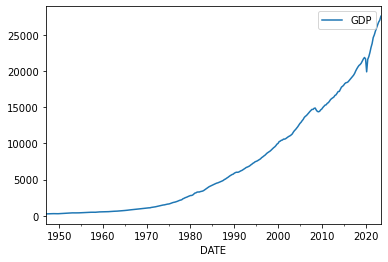

In [3]:
start_date = '1900-01-01'
data = pdr.DataReader('GDP', 'fred', start_date)
data[data.columns[0]].plot()
plt.legend([data.columns[0]])
plt.show()

## SARIMA Model

In [4]:
pmax  = 2 #maximum lag on regular auto regressive
qmax = 2 #maximum lag on regular ma
Pmax = 2 #maximum lag on seasonalty auto regressive
Qmax = 2 #maximum lag on seasonality moving average
fsteps = 12 #steps for forecasting
seasonality = 4
model = sarima_model(data['GDP'].iloc[:-fsteps], pmax, qmax, Pmax, Qmax, seasonality)
model.get_optimal_sarima_model()
actual_values = data['GDP'].iloc[-fsteps:]
sarima_forecast = model.forecast(steps=fsteps, actual_values = actual_values)

Model No. 1 ARIMA (0, 1, 0)(0, 1, 0) [4], AIC = 3781.2, time = 3.4 sec
Model No. 2 ARIMA (0, 1, 0)(0, 1, 1) [4], AIC = 3715.7, time = 0.2 sec
Model No. 3 ARIMA (0, 1, 0)(0, 1, 2) [4], AIC = 3668.8, time = 0.3 sec
Model No. 4 ARIMA (0, 1, 0)(1, 1, 0) [4], AIC = 3741.9, time = 0.1 sec
Model No. 5 ARIMA (0, 1, 0)(1, 1, 1) [4], AIC = 3717.5, time = 0.3 sec
Model No. 6 ARIMA (0, 1, 0)(1, 1, 2) [4], AIC = 3669.5, time = 0.4 sec
Model No. 7 ARIMA (0, 1, 0)(2, 1, 0) [4], AIC = 3684.1, time = 0.1 sec
Model No. 8 ARIMA (0, 1, 0)(2, 1, 1) [4], AIC = 3680.9, time = 0.6 sec
Model No. 9 ARIMA (0, 1, 0)(2, 1, 2) [4], AIC = 3670.0, time = 0.5 sec
Model No. 10 ARIMA (0, 1, 1)(0, 1, 0) [4], AIC = 3753.3, time = 0.2 sec
Model No. 11 ARIMA (0, 1, 1)(0, 1, 1) [4], AIC = 3676.5, time = 0.3 sec
Model No. 12 ARIMA (0, 1, 1)(0, 1, 2) [4], AIC = 3627.9, time = 0.4 sec
Model No. 13 ARIMA (0, 1, 1)(1, 1, 0) [4], AIC = 3725.9, time = 0.1 sec
Model No. 14 ARIMA (0, 1, 1)(1, 1, 1) [4], AIC = 3677.7, time = 0.4 sec
M

In [5]:
sarima_forecast

,Forecast,Actual,error
DATE,,,
2020-10-01,21547.252969,22024.502,2.2
2021-01-01,21594.190020,22600.185,4.5
2021-04-01,21128.048388,23292.362,9.3
2021-07-01,21813.213221,23828.973,8.5
2021-10-01,21889.628031,24654.603,11.2
2022-01-01,22026.636961,25029.116,12.0
2022-04-01,22084.463763,25544.273,13.5
2022-07-01,22377.100387,25994.639,13.9
2022-10-01,22530.647066,26408.405,14.7


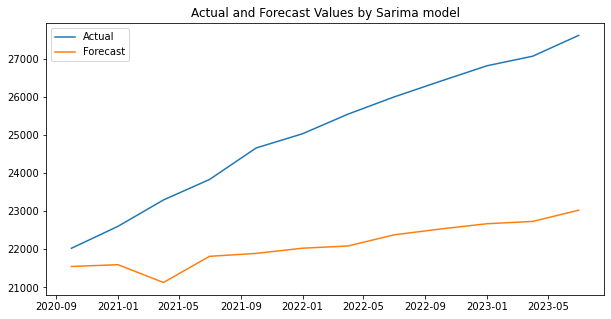

In [6]:
plot_forecast(sarima_forecast['Actual'], sarima_forecast['Forecast'],
              title = 'Actual and Forecast Values by Sarima model')

## Facebook Prophete

In [7]:
prophte_data = data.reset_index().copy()
prophte_data.columns = ['ds', 'y']

In [8]:
model = Prophet().fit(prophte_data.iloc[:-fsteps])
future = model.make_future_dataframe(periods=fsteps, freq='Q')
prophet_forecast = model.predict(future)[['ds', 'yhat']].iloc[-fsteps:].set_index('ds')

20:10:00 - cmdstanpy - INFO - Chain [1] start processing
20:10:00 - cmdstanpy - INFO - Chain [1] done processing


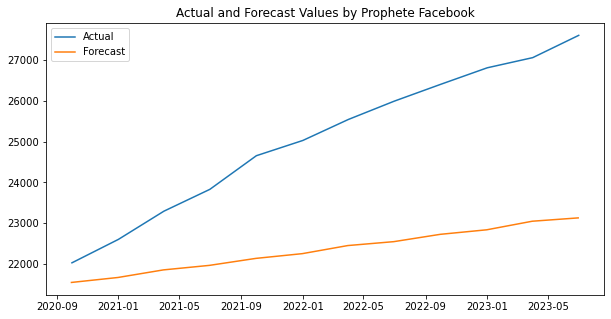

In [9]:
plot_forecast(actual_values, prophet_forecast['yhat'],
              title = 'Actual and Forecast Values by Prophete Facebook')

## Neural Network

In [10]:
def ANNforecast(y, fsteps, take_log=False):
    y_index = y.index
    y = y.values.reshape(-1, 1)
    if take_log:
        y = np.log(y)
        
    scaler = MinMaxScaler().fit(y)
    y = scaler.transform(y)
    lag = int(len(y)/4)
    X = lagmat(y, maxlag=lag, trim='None', original='ex')
    X = X[lag:len(y), :]
    yadj = y[lag:len(y)]
    nernum = 50
    netmax = 100
    nn_model = MLPRegressor(hidden_layer_sizes=(nernum, nernum,),
                            solver = 'lbfgs', activation='tanh', max_iter=10000)
    Yf0 = np.zeros((fsteps, 1))
    for n in range(0, netmax):
        fitted_nn_model = nn_model.fit(X, yadj)
        yf = np.zeros((fsteps, 1))
        yandyf = y
        for i in range(0, fsteps):
            Tn = len(yandyf)
            Xf = lagmat(yandyf, maxlag=lag-1, trim='None', original='in')
            Xf = Xf[lag-1: Tn, :]
            Xf = Xf[-1, :].reshape(1, -1)
            yf[i, 0] = fitted_nn_model.predict(Xf)[0]
            yandyf = np.vstack((yandyf.reshape(Tn, 1), (yf[i, 0])))
        
        yf = scaler.inverse_transform(yf)
        Yf0 = Yf0 + yf
    Yf = Yf0/netmax
    
    if take_log:
        Yf = np.exp(Yf)
        
    Yf = pd.Series(Yf.reshape(1, -1).tolist()[0], name = 'ANN')
    Yf.index = y_index[-fsteps:]
    return Yf

In [11]:
ANN_forecast = ANNforecast(y = (data['GDP']), fsteps=12)

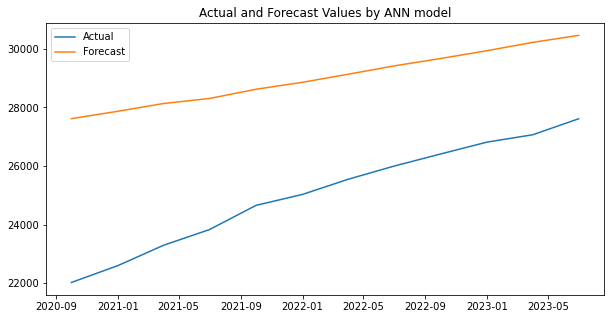

In [12]:
plot_forecast(actual_values = data['GDP'].iloc[-fsteps:],
              Forecast_values=ANN_forecast,
              title = 'Actual and Forecast Values by ANN model')

## Outputs

In [13]:
forecast_data = pd.concat([ANN_forecast,
           sarima_forecast[['Forecast']].rename({'Forecast': 'Sarima'}, axis=1),
           prophet_forecast.set_index(ANN_forecast.index).rename({'yhat': 'FaceBook'}, axis=1)
           ],
          axis=1)

forecast_data['mean'] = forecast_data.mean(axis=1)

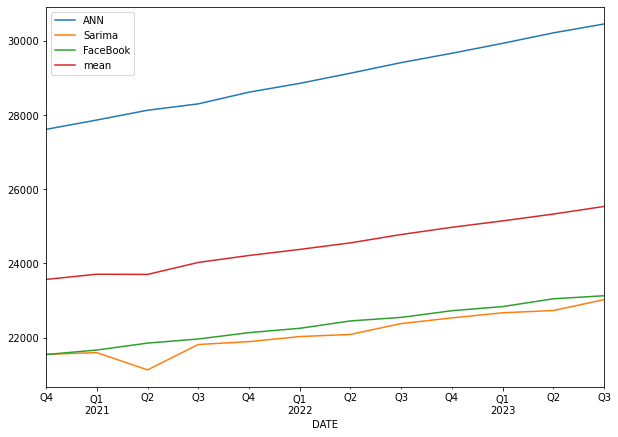

In [14]:
forecast_data.plot(figsize=(10, 7))
plt.show()

## other datas

In [41]:
def combined_prediction(y, models=['sarima', 'facebook', 'ANN'],
                        take_log=False, fsteps=12, seasonality=12, freq='Q'):
    
    forecast_data = pd.DataFrame()
    y = y.dropna()
    
    if take_log:
        y = np.log(y)

    if 'sarima' in models:
        model = sarima_model(y.iloc[:-fsteps], pmax=pmax, qmax=qmax, Pmax=Pmax, Qmax=Qmax, seasonality=seasonality)
        model.get_optimal_sarima_model()
        actual_values = y.iloc[-fsteps:]
        sarima_forecast = model.forecast(steps=fsteps, actual_values = actual_values)
        sarima_forecast = sarima_forecast['Forecast'].rename('Sarima')
        forecast_data = pd.concat([forecast_data, sarima_forecast], axis=1)
        
    if 'ANN' in models:
        ANN_forecast = ANNforecast(y=y, fsteps=12)
        forecast_data = pd.concat([forecast_data, ANN_forecast], axis=1)
        
    if 'facebook' in models:
        data = pd.DataFrame(y)
        prophte_data = data.reset_index().copy()
        prophte_data.columns = ['ds', 'y']
        prophte_data['ds'] = pd.to_datetime(prophte_data['ds'].astype('str').str[:10])
        model = Prophet().fit(prophte_data.iloc[:-fsteps])
        future = model.make_future_dataframe(periods=fsteps, freq=freq)
        prophet_forecast = model.predict(future)[['ds', 'yhat']].iloc[-fsteps:].set_index('ds')
        prophet_forecast = prophet_forecast.set_index(y[-fsteps:].index).rename({'yhat': 'FaceBook'}, axis=1)
        forecast_data = pd.concat([forecast_data, prophet_forecast], axis=1)

        
    if take_log:
        forecast_data =np.exp(forecast_data)
        
    forecast_data['mean'] = forecast_data.mean(axis=1)
        
    return forecast_data
    

- 5-years of 10-year constant maturity yields on U.S. government bonds

In [42]:
pmax  = 1 #maximum lag on regular auto regressive
qmax = 1 #maximum lag on regular ma
Pmax = 1 #maximum lag on seasonalty auto regressive
Qmax = 1 #maximum lag on seasonality moving average
fsteps = 12 #steps for forecasting
seasonality = 12

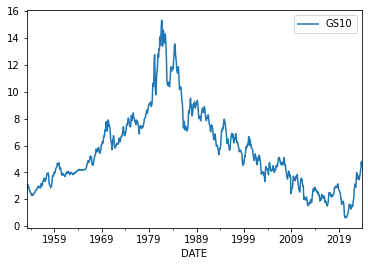

In [43]:
start_date = '1900-01-01'
data = pdr.DataReader('GS10', 'fred', start_date)
data[data.columns[0]].plot()
plt.legend([data.columns[0]])
plt.show()

In [44]:
forecast_data = combined_prediction(y = data['GS10'], models=['sarima', 'facebook', 'ANN'],
                                    take_log=False, fsteps=12, seasonality=12, freq='M')

Model No. 1 ARIMA (0, 1, 0)(0, 0, 0) [12], AIC = 748.7, time = 0.6 sec
Model No. 2 ARIMA (0, 1, 0)(0, 0, 1) [12], AIC = 204.8, time = 3.3 sec
Model No. 3 ARIMA (0, 1, 0)(1, 0, 0) [12], AIC = 518.7, time = 1.6 sec
Model No. 4 ARIMA (0, 1, 0)(1, 0, 1) [12], AIC = 212.0, time = 4.3 sec
Model No. 5 ARIMA (0, 1, 1)(0, 0, 0) [12], AIC = 650.9, time = 0.4 sec
Model No. 6 ARIMA (0, 1, 1)(0, 0, 1) [12], AIC = 90.5, time = 3.0 sec
Model No. 7 ARIMA (0, 1, 1)(1, 0, 0) [12], AIC = 402.9, time = 1.7 sec
Model No. 8 ARIMA (0, 1, 1)(1, 0, 1) [12], AIC = 93.7, time = 3.8 sec
Model No. 9 ARIMA (1, 1, 0)(0, 0, 0) [12], AIC = 683.6, time = 0.2 sec
Model No. 10 ARIMA (1, 1, 0)(0, 0, 1) [12], AIC = 127.0, time = 3.4 sec
Model No. 11 ARIMA (1, 1, 0)(1, 0, 0) [12], AIC = 444.3, time = 1.8 sec
Model No. 12 ARIMA (1, 1, 0)(1, 0, 1) [12], AIC = 131.7, time = 5.1 sec
Model No. 13 ARIMA (1, 1, 1)(0, 0, 0) [12], AIC = 629.5, time = 0.8 sec
Model No. 14 ARIMA (1, 1, 1)(0, 0, 1) [12], AIC = 85.7, time = 4.5 sec
Mode

20:50:18 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing


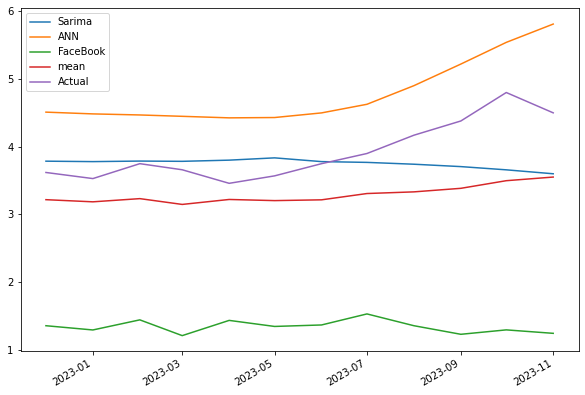

In [45]:
forecast_data['Actual'] = data['GS10'][-fsteps:]
forecast_data.plot(figsize=(10, 7))
plt.show()

- Tesla Price

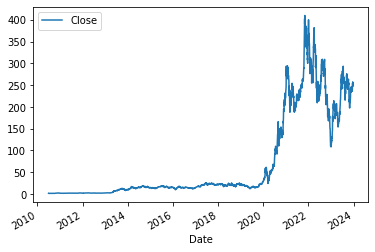

In [51]:
symbol = 'TSLA'
data = yf.Ticker(symbol).history(period="20y")[['Close']]
data[data.columns[0]].plot()
plt.legend([data.columns[0]])
plt.show()

In [52]:
forecast_data = combined_prediction(y = data['Close'], models=['sarima', 'facebook', 'ANN'],
                                    take_log=True, fsteps=12, seasonality=7, freq='D')

Model No. 1 ARIMA (0, 1, 0)(0, 0, 0) [7], AIC = -10653.0, time = 1.5 sec
Model No. 2 ARIMA (0, 1, 0)(0, 0, 1) [7], AIC = -12402.7, time = 1.9 sec
Model No. 3 ARIMA (0, 1, 0)(1, 0, 0) [7], AIC = -11563.9, time = 2.7 sec
Model No. 4 ARIMA (0, 1, 0)(1, 0, 1) [7], AIC = -12434.3, time = 2.4 sec
Model No. 5 ARIMA (0, 1, 1)(0, 0, 0) [7], AIC = -10655.1, time = 1.2 sec
Model No. 6 ARIMA (0, 1, 1)(0, 0, 1) [7], AIC = -12826.6, time = 9.2 sec
Model No. 7 ARIMA (0, 1, 1)(1, 0, 0) [7], AIC = -11562.5, time = 2.2 sec
Model No. 8 ARIMA (0, 1, 1)(1, 0, 1) [7], AIC = -12442.1, time = 3.6 sec
Model No. 9 ARIMA (1, 1, 0)(0, 0, 0) [7], AIC = -10651.0, time = 0.9 sec
Model No. 10 ARIMA (1, 1, 0)(0, 0, 1) [7], AIC = -12411.1, time = 3.0 sec
Model No. 11 ARIMA (1, 1, 0)(1, 0, 0) [7], AIC = -11558.9, time = 3.0 sec
Model No. 12 ARIMA (1, 1, 0)(1, 0, 1) [7], AIC = -12445.9, time = 3.0 sec
Model No. 13 ARIMA (1, 1, 1)(0, 0, 0) [7], AIC = -10683.1, time = 2.9 sec
Model No. 14 ARIMA (1, 1, 1)(0, 0, 1) [7], AIC 

21:00:39 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing


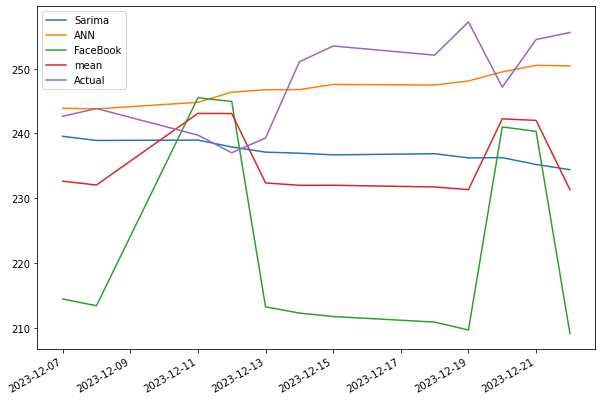

In [53]:
forecast_data['Actual'] = data['Close'][-fsteps:]
forecast_data.plot(figsize=(10, 7))
plt.show()